In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pickle
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score

In [2]:
# M = 100 * torch.eye(100) + 10 * torch.rand(100,100)
# M_half = torch.cholesky(M)
# M_inv = torch.inverse(M)
# M_half_inv = torch.inverse(M_half)
# x = torch.randn(1, 100)
# y = x @ M_inv
# y2 = rec_model.chol_inv(M_half, x, left=False)
# print(y - y2)



In [3]:
# v = torch.randn(4, 2, 10)
# Y = torch.randint(0, 10, (4, 5, 10)).float()
# # print(v, Y)
# lik = Poisson_noise()
# model = LDS(v, Y, lik, x_dim=12)
# rec_model = RecognitionModel(model)
# rec_model.get_x_tilde(Y).shape

In [2]:
torch.manual_seed(1)
np.random.seed(1)
v = torch.randn(4, 2, 10)
# Y = torch.randn(4, 5, 10)
Y = torch.randint(0, 10, (4, 5, 10)).float()
# print(v, Y)
lik = Poisson_noise()
model = LDS(v, Y, lik)
# model.joint_LL(3)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 5e-2, 'max_steps': 1001}
model.train_supervised_model(model.training_params(**train_params))

/home/ayush/anaconda3/lib/python3.11/site-packages/torch/optim/adam.py:33: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super().__init__(params, defaults)


step 0 LL -6240.57177734375
step 1 LL -570.3846435546875
step 2 LL -374.7864685058594
step 3 LL -309.9374694824219
step 4 LL -268.8320007324219
step 5 LL -250.84422302246094
step 6 LL -237.86585998535156
step 7 LL -227.91140747070312
step 8 LL -218.6330108642578
step 9 LL -220.22314453125
step 10 LL -211.80950927734375
step 11 LL -214.05099487304688
step 12 LL -212.45664978027344
step 13 LL -213.16201782226562
step 14 LL -212.58682250976562
step 15 LL -208.65179443359375
step 16 LL -206.33184814453125
step 17 LL -203.00997924804688
step 18 LL -206.91465759277344
step 19 LL -206.38113403320312
step 20 LL -204.84898376464844
step 21 LL -206.78512573242188
step 22 LL -201.83786010742188
step 23 LL -203.68173217773438
step 24 LL -204.0198211669922
step 25 LL -203.22744750976562
step 26 LL -200.75839233398438
step 27 LL -199.65646362304688
step 28 LL -201.14181518554688
step 29 LL -200.3380126953125
step 30 LL -200.0778045654297
step 31 LL -198.68997192382812
step 32 LL -198.66409301757812


In [3]:
model.freeze_params()
rec_model = RecognitionModel(model)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 5e-2, 'max_steps': 1001, 'n_mc_x': 100, 'n_mc_z': 100}
rec_model.train_recognition_model(rec_model.training_params(**train_params))

step 0 LL -159.1348114013672
step 1 LL -172.53773498535156
step 2 LL -155.85116577148438
step 3 LL -156.67935180664062
step 4 LL -157.41917419433594
step 5 LL -156.7660369873047
step 6 LL -155.9107666015625
step 7 LL -155.35723876953125
step 8 LL -154.9781494140625
step 9 LL -154.86868286132812
step 10 LL -154.7714385986328
step 11 LL -154.46177673339844
step 12 LL -154.6331787109375
step 13 LL -154.38893127441406
step 14 LL -154.5660400390625
step 15 LL -154.52731323242188
step 16 LL -154.36349487304688
step 17 LL -154.3740234375
step 18 LL -154.30294799804688
step 19 LL -154.12950134277344
step 20 LL -154.01361083984375
step 21 LL -154.1339569091797
step 22 LL -154.0719757080078
step 23 LL -153.87628173828125
step 24 LL -154.13461303710938
step 25 LL -154.0201873779297
step 26 LL -154.10098266601562
step 27 LL -154.00640869140625
step 28 LL -154.12728881835938
step 29 LL -154.05352783203125
step 30 LL -154.12277221679688
step 31 LL -153.944580078125
step 32 LL -153.94219970703125
ste

(2,) (2, 2)


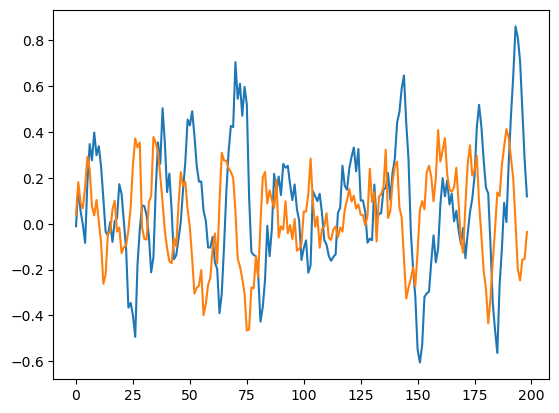

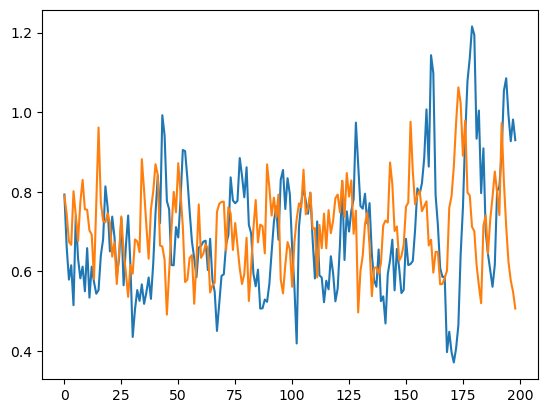

In [4]:
# Simulate some data
torch.manual_seed(0)
np.random.seed(0)
N = 10
x_dim = 2

A = np.array([[0.9, 0.4], [-0.2, 0.8]])
B = np.array([[0.1, 0.0], [0.0, 0.1]])
# W = np.array([[0.5, 0.5], [0.5, 0.5]])
W = np.array([[1, 0], [0, 1]])
# C = np.random.randn(N, x_dim)
# Have C to be multiple identity matrices
C = np.vstack([np.eye(x_dim)] * (N//x_dim))
sigma_x = 0.1

mu0 = np.array([0., 0.])
Sigma0 = np.array([[.010, 0.0], [0.0, .010]])
print(mu0.shape, Sigma0.shape)

ntrials = 5
# v0 = np.random.multivariate_normal(mu0, Sigma0)
v0 = mu0 + (np.linalg.cholesky(Sigma0) @ np.random.randn(ntrials,2, 1)).squeeze(-1)

T = 200
v = np.zeros((ntrials,2,T))
x = np.zeros((ntrials,x_dim,T))
x_noise_free = np.zeros((ntrials,x_dim,T))
v[:,:, 0] = v0
x_noise_free[:,:, 0] = (W @ v0[..., None]).squeeze(-1)
x[:,:, 0] = (W @ v0[..., None]).squeeze(-1) + sigma_x * np.random.randn(ntrials, x_dim,)
for t in range(1, T):
    v[..., t] = (A @ v[..., t-1][..., None]).squeeze(-1) + (B @ np.random.randn(ntrials, 2,1)).squeeze(-1)
    x_noise_free[..., t] = (W @ v[..., t][..., None]).squeeze(-1)
    x[..., t] = (W @ v[..., t][..., None]).squeeze(-1) + sigma_x * np.random.randn(ntrials, x_dim)

stop = -1
plt.plot(v[-1,0,:stop])
plt.plot(v[-1,1,:stop])
plt.show()

F = C[None, ...] @ x

# link = np.exp
link = lambda x: np.log(1 + np.exp(x))
plt.plot(link(F[0,0,:stop]))
plt.plot(link(F[0,1,:stop]))
plt.show()


In [12]:
# link_fn = torch.exp

# link_fn = torch.nn.functional.softplus
# lik = Poisson_noise()
# Y = np.random.poisson(link(F))

sigma = 0.1
Y = np.random.randn(*F.shape) * sigma + F
lik = Gaussian_noise(sigma)
link_fn = lambda x: x

# # Y = np.random.negative_binomial()
# lik = Negative_binomial_noise(Y)
# link_fn = lambda x:x

# model = LDS(Tensor(v), Tensor(Y), lik, x_dim=x_dim, link_fn=link_fn)
# train_params = {'batch_size': None, 'n_mc': 500, 'step_size': 100, 'lrate': 5e-3, 'max_steps': 1001}
# np.random.seed(0)
# torch.manual_seed(0)
# model.train_supervised_model(model.training_params(**train_params))
# model.plot_LL()

# Fixed generative model
model = LDS(Tensor(v), Tensor(Y), lik, x_dim=x_dim, link_fn=link_fn, 
            A=Tensor(A[None, ...]).to(device), B=Tensor(B[None, ...]).to(device), W=Tensor(W[None,...]).to(device), C=Tensor(C[None, ...]).to(device),
            mu0=Tensor(mu0[None, ...]).to(device), Sigma0_half=Tensor(np.linalg.cholesky(Sigma0)[None, ...]).to(device),
            sigma_x=Tensor([sigma_x]).to(device))

In [13]:
for name, prm in model.named_parameters():
    if name in ['C', 'W']:
        continue
    print(f'Name: {name} - Shape: {prm.shape} - Parameter: {prm}')


# print(C @ W )
# print(model.C @ model.W)
print(C@W - (model.C @ model.W).detach().cpu().numpy())

Name: A - Shape: torch.Size([1, 2, 2]) - Parameter: Parameter containing:
tensor([[[ 0.9000,  0.4000],
         [-0.2000,  0.8000]]], device='cuda:0', requires_grad=True)
Name: B - Shape: torch.Size([1, 2, 2]) - Parameter: Parameter containing:
tensor([[[0.1000, 0.0000],
         [0.0000, 0.1000]]], device='cuda:0', requires_grad=True)
Name: log_sigma_x - Shape: torch.Size([1]) - Parameter: Parameter containing:
tensor([-2.3026], device='cuda:0', requires_grad=True)
Name: mu0 - Shape: torch.Size([1, 2]) - Parameter: Parameter containing:
tensor([[0., 0.]], device='cuda:0', requires_grad=True)
Name: Sigma0_half - Shape: torch.Size([1, 2, 2]) - Parameter: Parameter containing:
tensor([[[0.1000, 0.0000],
         [0.0000, 0.1000]]], device='cuda:0', requires_grad=True)
Name: lik.log_sigma - Shape: torch.Size([]) - Parameter: Parameter containing:
tensor(-2.3026, device='cuda:0', dtype=torch.float64, requires_grad=True)
[[[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]


torch.Size([1, 5, 2, 200])


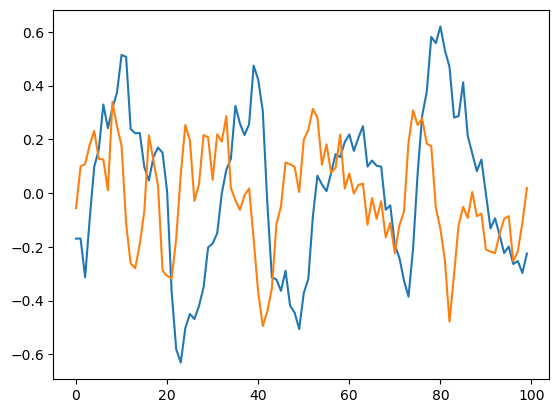

In [14]:
model.freeze_params()
z_samps = model.sample_z(1)
print(z_samps.shape)
stop = 100
for i in range(len(z_samps)):
    plt.plot(z_samps[i,0,0, :stop].detach().cpu().numpy())
    plt.plot(z_samps[i,0,1, :stop].detach().cpu().numpy())
    plt.show()

step 0 LL -612.2462445515765
step 1 LL -643.6983623847487
step 2 LL -670.3552151162935
step 3 LL -596.1090261754074
step 4 LL -598.9155172665014
step 5 LL -589.300656416658
step 6 LL -615.3898301918471
step 7 LL -555.276169406332
step 8 LL -596.8140672972216
step 9 LL -587.9973496596684
step 10 LL -605.2128494989046
step 11 LL -563.3530539547154
step 12 LL -542.2366237052596
step 13 LL -542.6677969440187
step 14 LL -577.7588421275075
step 15 LL -533.1833438055883
step 16 LL -548.3192078732562
step 17 LL -520.5670164606474
step 18 LL -506.46374161647236
step 19 LL -495.092631951285
step 20 LL -524.0040528301987
step 21 LL -478.92852025525156
step 22 LL -543.8396247975531
step 23 LL -484.90028129799276
step 24 LL -469.8583481383213
step 25 LL -486.1486628628196
step 26 LL -460.44060212311854
step 27 LL -442.38546002966837
step 28 LL -460.86089768663373
step 29 LL -474.30874473582844
step 30 LL -418.3872206651895
step 31 LL -431.7862477329126
step 32 LL -468.43783371830506
step 33 LL -471

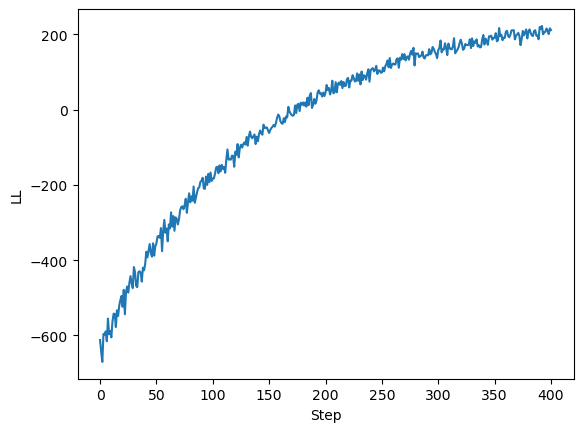

In [16]:

model.freeze_params()
# Substituting the true parameters
neural_net = torch.nn.Sequential(
                torch.nn.Linear(model.N, 60),
                torch.nn.Sigmoid(),
                torch.nn.Linear(60, 60),
                torch.nn.Sigmoid(),
                torch.nn.Linear(60, model.x_dim)
            )
rec_model = RecognitionModel(model)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 1e-4, 'max_steps': 401, 'n_mc_x': 50, 'n_mc_z': 50}
rec_model.train_recognition_model(rec_model.training_params(**train_params))
rec_model.plot_LL()

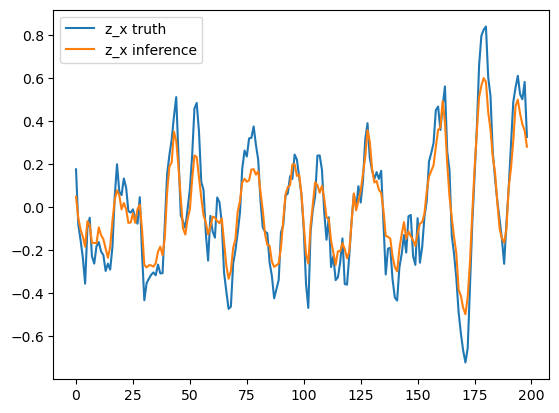

0.7887408929715983
0.8786433985366962
(5, 2, 200)


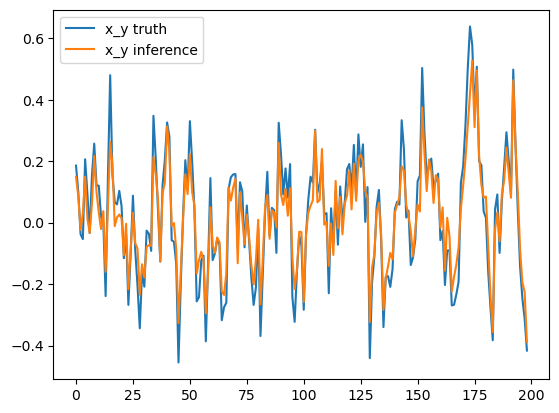

0.9155620401808159 x_x
0.8964472490682382 x_y
(5, 2, 200)


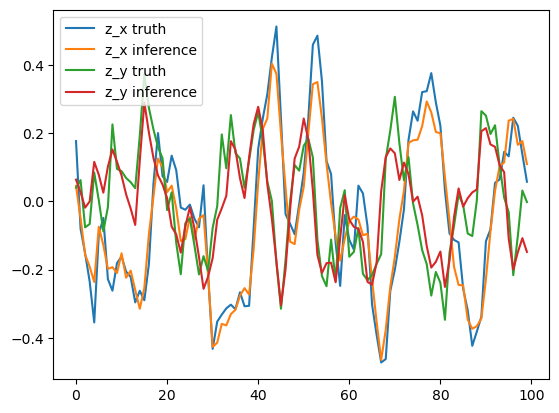

0.873410011253871
0.9556902780122127


In [20]:
z = rec_model.test_z(rec_model.gen_model.Y)
z = z.detach().cpu().numpy()

stop = -1
plt.plot(v[0,0,:stop], label = 'z_x truth')
# plt.plot(v[0,1,:100], label = 'z_y truth')
plt.plot(z[0,0,:stop], label = 'z_x inference')
# plt.plot(z[0,1,:100], label = 'z_y inference')
plt.legend()
plt.show()

# # print MSE for x and y decoding
# print(np.square(v[0,1,:] - z[0,1,:]).mean())
# print(np.square(v[0,0,:] - z[0,0,:]).mean())

# print R^2 for x and y decoding using sklearn
print(r2_score(v[0,1,:], z[0,1,:]))
print(r2_score(v[0,0,:], z[0,0,:]))


x_tilde = rec_model.get_x_tilde(rec_model.gen_model.Y).detach().cpu().numpy()
print(x_tilde.shape)
stop = -1
# plt.plot(x[0,0,:stop], label = 'x_x truth')
# plt.plot(x_tilde[0,0,:stop], label = 'x_x inference')
plt.plot(x[0,1,:stop], label = 'x_y truth')
plt.plot(x_tilde[0,1,:stop], label = 'x_y inference')
plt.legend()
plt.show()
# print R^2 for x_tilde
print(r2_score(x[0,0,:], x_tilde[0,0,:]), 'x_x')
print(r2_score(x[0,1,:], x_tilde[0,1,:]), 'x_y')

_, _, Ks, Cs = rec_model.kalman_covariance() # TODO: should I use prev_mu and prev_Sigma?
_ , mus_smooth, _ = rec_model.kalman_means(Tensor(x_noise_free[None, ...]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
# _ , mus_smooth, _ = rec_model.kalman_means(Tensor(x[None, ...]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
mus_smooth = mus_smooth.detach().cpu().numpy().squeeze(1).transpose(1, 2, 0)
print(mus_smooth.shape)
stop = 100
plt.plot(v[0,0,:stop], label = 'z_x truth')
plt.plot(mus_smooth[0, 0,:stop], label = 'z_x inference')
plt.plot(v[0,1,:stop], label = 'z_y truth')
plt.plot(mus_smooth[0, 1,:stop], label = 'z_y inference')
plt.legend()
plt.show()

# print R^2 for x and y smoothing using sklearn
print(r2_score(v[0,1,:], mus_smooth[0, 1,:]))
print(r2_score(v[0,0,:], mus_smooth[0, 0,:]))


In [ ]:
# Checking what sampled posteriors look like
matheron_pert = rec_model.sample_matheron_pert(100)
print(matheron_pert.shape)
x_hat = Tensor(x[None, ...]).to(device) - matheron_pert[..., :x_tilde.shape[-1]]
print(x_hat.shape)
_, _, Ks, Cs = rec_model.kalman_covariance() # TODO: should I use prev_mu and prev_Sigma?
_ , _mus_smooth, _ = rec_model.kalman_means(x_hat, Ks, Cs) # (batch_size, n_mc_z, ntrials, b)
_mus_smooth = _mus_smooth.permute(1,2,3,0).squeeze().detach().cpu().numpy()
print(_mus_smooth.shape)


# # Find the prior mean
# z_samps = model.sample_z(10000)
# z_samps = z_samps.squeeze().detach().cpu().numpy()
# print(z_samps.shape)

torch.Size([100, 1, 2, 5000])
torch.Size([100, 1, 2, 5000])
(100, 2, 5000)


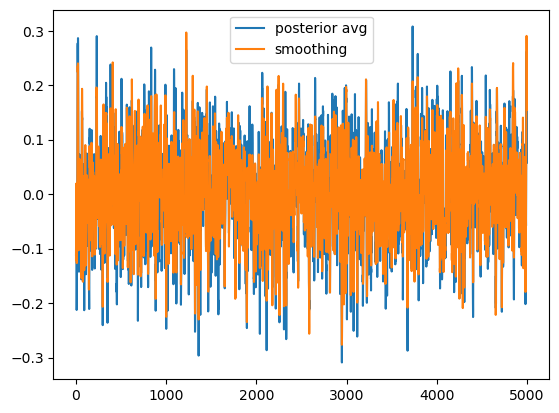

0.7522298766551174
0.86521357134445


In [ ]:
# stop = 100
# for i in range(len(_mus_smooth)):
#     plt.plot(_mus_smooth[i,0,:stop])
#     # plt.plot(_mus_smooth[i,0,1,:stop])
#     # plt.show()
# plt.show()

stop = -1
posterior_avg = _mus_smooth.mean(0)
prior_avg = z_samps.mean(0)
plt.plot(posterior_avg[0,:stop], label = 'posterior avg')
plt.plot(mus_smooth[0,:stop], label = 'smoothing')
# plt.plot(prior_avg[0,:stop], label = 'prior avg')
# plt.plot(z_samps[0,0,:stop], label = 'prior sample')
plt.legend()
plt.show()
# print R^2 between posterior mean and smoothing
print(r2_score(mus_smooth[0,:], posterior_avg[0,:]))
print(r2_score(mus_smooth[1,:], posterior_avg[1,:]))

In [ ]:
# # Natural parameters for p(v_t|v_{t-1})
# mus = self.A @ v[... , :-1] # (ntrials, b, T-1)
# # print(mu.shape, self.Q.shape)
# second_big = torch.zeros(ntrials).to(device)
# for t in range(T-1): # TODO, can we vectorize this?
#     dist = MultivariateNormal(mus[..., t], self.Q)
#     second_big += dist.log_prob(v[..., t+1])

# # # Replace the for loop with this code
# # dist = MultivariateNormal(mus, self.Q[..., None])
# # second_big = dist.log_prob(v[..., 1:]).sum(dim=-1)

mus = torch.zeros(4, 2, 9)
Q = torch.eye(2)[None, ...]
# Q = Q.expand(4, -1, -1)
v = torch.zeros(4, 2, 10)
print(mus.shape, Q.shape)

T = 10
second_big = torch.zeros(4)
for t in range(T-1): # TODO, can we vectorize this?
    print(mus[..., t].shape, Q.shape)
    dist = MultivariateNormal(mus[..., t], Q)
    second_big += dist.log_prob(v[..., t+1])

print(second_big.shape, second_big)

# Replace the for loop with this code
# dist = MultivariateNormal(mus, Q[..., None].expand(-1, -1, -1, mus.shape[-1]))
# second_big = dist.log_prob(v[..., 1:]).sum(dim=-1)
# print(second_big.shape, second_big)
# mus = mus.transpose(-1,-2)
# print(mus.shape)
mus = mus.transpose(-1,-2)
# Q = Q[:, None, ...].expand(-1, mus.shape[1], -1, -1)
Q = Q[:, None, ...]
print(Q.shape, mus.shape)
dist = MultivariateNormal(mus, Q)
v = v[..., 1:].transpose(-1,-2)
print(v.shape)
second_big = dist.log_prob(v).sum(dim=-1)
print(second_big.shape, second_big)


torch.Size([4, 2, 9]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4, 2]) torch.Size([1, 2, 2])
torch.Size([4]) tensor([-16.5409, -16.5409, -16.5409, -16.5409])
torch.Size([1, 1, 2, 2]) torch.Size([4, 9, 2])
torch.Size([4, 9, 2])
torch.Size([4]) tensor([-16.5409, -16.5409, -16.5409, -16.5409])


In [2]:
data = pickle.load(open('data/Doherty_example.pickled', 'rb')) # load example data
binsize = 25 # binsize in ms
data_len = 1000 # number of time bins to use for fitting
timepoints = np.arange(0, data_len) #subsample ~40 seconds of data so things will run somewhat quicker
print(data['Y'].shape)
fit_data = {'Y': data['Y'][..., timepoints], 'locs': data['locs'][timepoints, :], 'targets': data['targets'][timepoints, :], 'binsize': binsize}
# fit_data = {'Y': data['Y'], 'locs': data['locs'], 'targets': data['targets'], 'binsize': binsize}
Y = fit_data['Y'] # these are the actual recordings and is the input to our model
targets = fit_data['targets'] # these are the target locations
locs = fit_data['locs'] # these are the hand positions

Y = Y[:, np.mean(Y,axis = (0, 2))/0.025 > 8, :] #subsample highly active neurons so things will run a bit quicker
# Y_test = Y[..., 1000:] # hold out some data for testing
# Y = Y[..., :1000] # use first 1000 time bins for training
print(Y.shape)
ntrials, n, T = Y.shape # Y should have shape: [number of trials (here 1) x neurons x time points]

ts = np.arange(Y.shape[-1])*fit_data['binsize'] # measured in ms
cs = CubicSpline(ts, locs) # fit cubic spline to behavior
vels = cs(ts, 1) # velocity (first derivative)


(1, 200, 70482)
(1, 102, 1000)


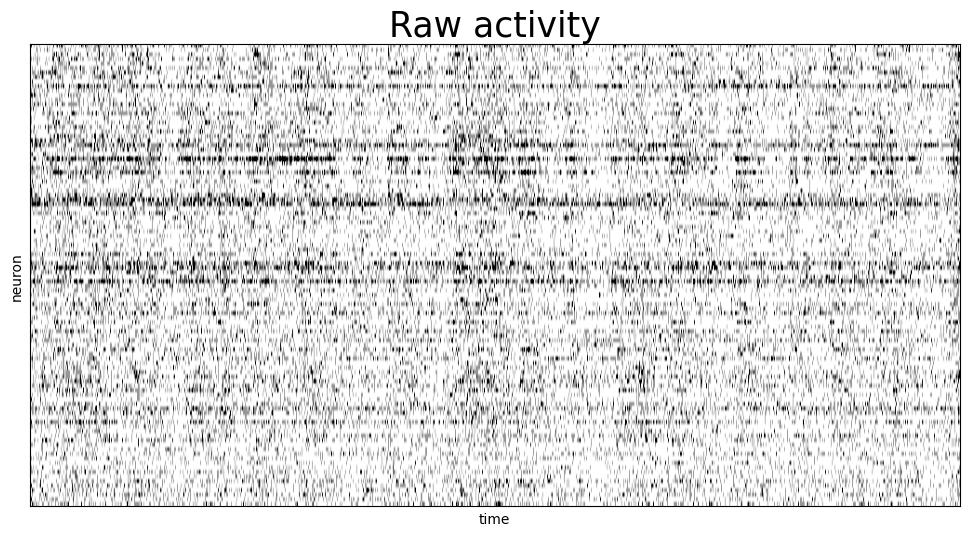

In [3]:
plt.figure(figsize = (12, 6))
plt.imshow(Y[0, ...], cmap = 'Greys', aspect = 'auto', vmin = np.quantile(Y, 0.01), vmax = np.quantile(Y, 0.99))
plt.xlabel('time')
plt.ylabel('neuron')
plt.title('Raw activity', fontsize = 25)
plt.xticks([])
plt.yticks([])
plt.show()

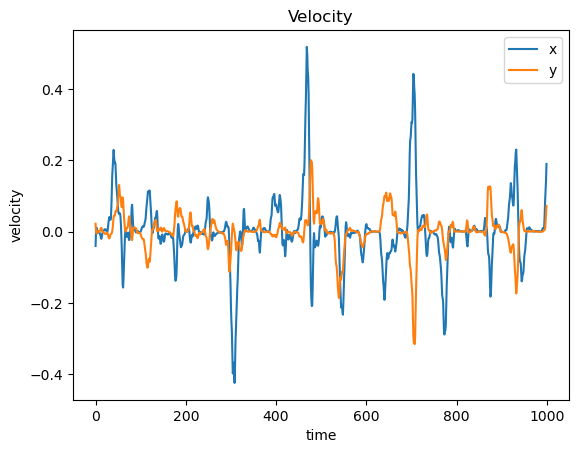

(1, 102, 1000) (1000, 2)


In [4]:
plt.plot(vels[:, 0], label = 'x')
plt.plot(vels[:, 1], label = 'y')
plt.legend()
plt.xlabel('time')
plt.ylabel('velocity')
plt.title('Velocity', fontsize = 12)
plt.show()

print(Y.shape, vels.shape)

/home/ayush/mgplvm-pytorch/main.py:361: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_count = torch.tensor(torch.mean(Y, dim=(0, 2))).to(device) # (N, )


torch.Size([1, 10, 1000])
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor([[[ 9.3132e-10,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.8626e-09, -5.0405e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -8.3378e-05, -1.2301e-04,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 9.3132e-10,  1.2648e-04,  1.4694e-04, -7.7048e-06,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  3.9527e-05,  6.0763e-05, -1.1455e-06, -6.3210e-03,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -2.6023e-04, -4.3751e-04, -3.0178e-05,  3.2178e-03,
          -7.1301e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        

/home/ayush/anaconda3/lib/python3.11/site-packages/torch/optim/adam.py:33: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super().__init__(params, defaults)


step 0 LL -53837.140625
step 1 LL -53653.140625
step 2 LL -53545.0703125
step 3 LL -53369.703125
step 4 LL -53232.8515625
step 5 LL -53047.0546875
step 6 LL -52947.484375
step 7 LL -52822.6015625
step 8 LL -52664.3359375
step 9 LL -52553.9140625
step 10 LL -52421.7734375
step 11 LL -52308.0546875
step 12 LL -52168.1328125
step 13 LL -52053.1640625
step 14 LL -51951.0859375
step 15 LL -51839.7265625
step 16 LL -51727.2109375
step 17 LL -51619.6015625
step 18 LL -51513.5703125
step 19 LL -51425.1953125
step 20 LL -51329.4921875
step 21 LL -51251.4140625
step 22 LL -51158.4140625
step 23 LL -51108.7578125
step 24 LL -51019.9765625
step 25 LL -50934.2265625
step 26 LL -50863.4140625
step 27 LL -50799.1875
step 28 LL -50716.2265625
step 29 LL -50676.6953125
step 30 LL -50621.2421875
step 31 LL -50572.7265625
step 32 LL -50520.8984375
step 33 LL -50461.2890625
step 34 LL -50415.5078125
step 35 LL -50385.1640625
step 36 LL -50328.5859375
step 37 LL -50293.828125
step 38 LL -50258.8984375
step

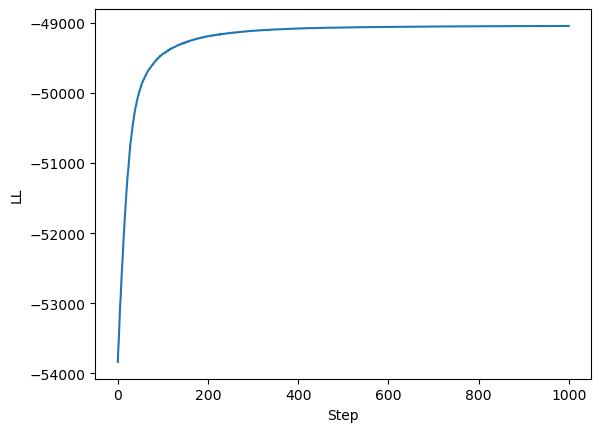

In [3]:
link_fn = torch.nn.functional.softplus
# lik = Poisson_noise()
lik = Negative_binomial_noise(Y=Tensor(Y))
np.random.seed(0)
torch.manual_seed(0)

# v = vels.T[None, ...]
# print(v.shape)
# model = LDS(Tensor(v), Tensor(Y), lik, link_fn=link_fn)
# train_params = {'batch_size': None, 'n_mc': 200, 'lrate': 5e-3}
# model.train_supervised_model(model.training_params(**train_params))
# model.plot_LL()

suffix = '10'

# Fixed generative model
z = Tensor(np.load('z_hat' + suffix + '.npy'))
print(z.shape)
A = Tensor(np.load('params/A' + suffix + '.npy'))[None, ...].to(device)
B = Tensor(np.load('params/B' + suffix + '.npy'))[None, ...].to(device)
W = np.load('params/W' + suffix + '.npy')
mu0 = Tensor(np.load('params/mu0' + suffix + '.npy'))[None, ...].to(device)
Sigma0_half = Tensor(np.load('params/Sigma0_half' + suffix + '.npy'))[None, ...].to(device)

def is_lower_triangular(tensor):
    return torch.all(tensor.triu(1) == 0)
print(is_lower_triangular(Tensor(Sigma0_half)))
print(is_lower_triangular(Tensor(B)))

print(B - torch.linalg.cholesky(B @ B.transpose(-1,-2)))

model = LDS(z, Tensor(Y), lik, link_fn=link_fn, A=A, B=B, mu0=mu0, Sigma0_half=Sigma0_half, trained_z=True)
train_params = {'batch_size': None, 'n_mc': 200, 'lrate': 5e-3, 'max_steps': 1001}
model.train_supervised_model(model.training_params(**train_params))
model.plot_LL()

In [9]:
for name, prm in model.named_parameters():
    print(f'Name: {name} - Shape: {prm.shape} - Parameter: {prm}')

print(model.lik.total_count)

Name: A - Shape: torch.Size([1, 10, 10]) - Parameter: Parameter containing:
tensor([[[ 0.4117, -0.2525, -0.1902, -0.0713, -0.2281,  0.0405,  0.1432,
           0.0448,  0.1584,  0.2847],
         [-0.2288,  0.0497, -0.1181, -0.0051, -0.5636, -0.0393,  0.0516,
          -0.1134,  0.0349, -0.1308],
         [-0.4626, -0.1700,  0.1298,  0.3584, -0.2188,  0.0028,  0.2196,
           0.2886, -0.0264,  0.5616],
         [ 0.1918,  0.2359,  0.2014,  0.5433,  0.5338, -0.2048,  0.1139,
          -0.0679, -0.2049, -0.0727],
         [ 0.0712,  0.1588,  0.0631,  0.3914,  0.1029,  0.1441, -0.1322,
           0.1452,  0.0519, -0.1002],
         [ 0.1788, -0.3454, -0.0897, -0.2799,  0.2802,  0.3487, -0.2461,
           0.2938,  0.0508, -0.0480],
         [ 0.3286,  0.1043,  0.1210, -0.2162,  0.1651,  0.0831, -0.1411,
          -0.4185,  0.1677, -0.1063],
         [-0.3659, -0.0437,  0.4344,  0.1460, -0.4098,  0.3955,  0.1846,
           0.3297, -0.0809, -0.0816],
         [-0.0898, -0.0028, -0.3349,

step 0 LL -90319.515625
step 1 LL -90303.78125
step 2 LL -90294.75
step 3 LL -90292.984375
step 4 LL -90285.75
step 5 LL -90281.546875
step 6 LL -90279.2734375
step 7 LL -90276.109375
step 8 LL -90270.3828125
step 9 LL -90274.4765625
step 10 LL -90262.828125
step 11 LL -90263.640625
step 12 LL -90260.390625
step 13 LL -90260.828125
step 14 LL -90261.4765625
step 15 LL -90257.9296875
step 16 LL -90256.0078125
step 17 LL -90259.59375
step 18 LL -90252.0625
step 19 LL -90260.140625
step 20 LL -90256.3125
step 21 LL -90259.578125
step 22 LL -90250.34375
step 23 LL -90247.453125
step 24 LL -90248.21875
step 25 LL -90240.53125
step 26 LL -90248.5078125
step 27 LL -90245.625
step 28 LL -90244.375
step 29 LL -90243.53125
step 30 LL -90244.4609375
step 31 LL -90242.7578125
step 32 LL -90239.3203125
step 33 LL -90243.765625
step 34 LL -90238.328125
step 35 LL -90239.1640625
step 36 LL -90239.25
step 37 LL -90239.0859375
step 38 LL -90239.53125
step 39 LL -90243.53125
step 40 LL -90240.546875
ste

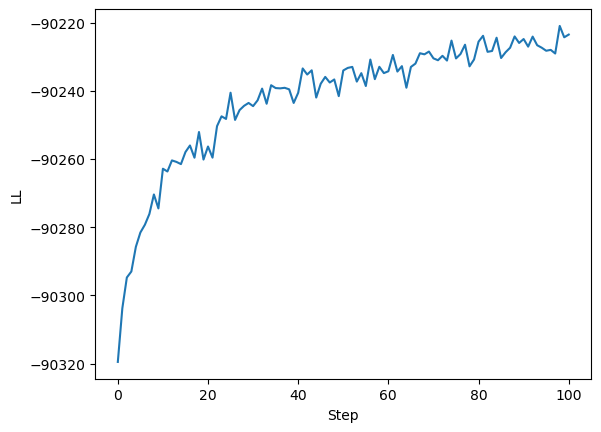

In [6]:
model.freeze_params()
rec_model = RecognitionModel(model)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 1e-3, 'max_steps': 101, 'n_mc_x': 50, 'n_mc_z': 50}
rec_model.train_recognition_model(rec_model.training_params(**train_params))
rec_model.plot_LL()

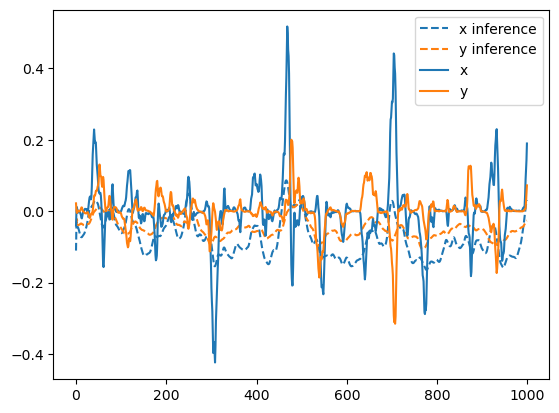

-0.42931615386871425
-0.6764134744222121


In [8]:
z = rec_model.test_z(rec_model.gen_model.Y)
z = z.detach().cpu().numpy()
z = W @ z
plt.plot(z[0,0,:], label = 'x inference', color = 'C0', linestyle = '--')
plt.plot(z[0,1,:], label = 'y inference', color = 'C1', linestyle = '--')
plt.plot(vels[:, 0], label = 'x', color = 'C0')
plt.plot(vels[:, 1], label = 'y', color = 'C1')
plt.legend()
plt.show()

# print R^2 for x and y decoding using sklearn
print(r2_score(vels[:, 0], z[0,0,:]))
print(r2_score(vels[:, 1], z[0,1,:]))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pickle
from scipy.interpolate import CubicSpline

In [ ]:
# Train 4G10 model
# z = np.load('4G10_z.npy')
# z = z.transpose(1,0, 2)
z = np.load('4G10_z_ayush.npy')
print(z.shape)
z = torch.Tensor(z)

Y_train = np.load('neural_train.npy')
Y_train = Y_train.transpose(1,0,2)
Y_train = torch.Tensor(Y_train)
print(Y_train.shape)

Y_test = np.load('neural_test.npy')
Y_test = Y_test.transpose(1,0,2)
Y_test = torch.Tensor(Y_test)
print(Y_test.shape)



(400, 10, 16)
torch.Size([400, 162, 16])
torch.Size([100, 162, 16])


In [ ]:


min_firing_rate = 0.1 # Hz
T_trial = 16 * 50 /1000 # seconds
print(Y_train.mean(dim=(0, 2))/T_trial)
Y_train = Y_train[:, Y_train.mean(dim=(0, 2))/T_trial > min_firing_rate, :]
print(Y_train.shape)

tensor([0.1023, 0.1711, 0.5150, 0.1553, 0.3377, 0.0291, 0.2096, 0.8529, 0.5342,
        0.4148, 0.1994, 0.0303, 0.0791, 1.2572, 0.0910, 0.8965, 0.3662, 0.0525,
        0.0348, 0.2645, 0.1555, 0.7842, 1.3041, 0.3535, 0.4150, 0.2262, 0.3520,
        0.5375, 0.2432, 0.4504, 0.0123, 0.2645, 0.1229, 0.1521, 0.3779, 0.2332,
        0.0055, 0.7191, 0.0266, 0.1424, 0.2758, 0.3250, 0.1600, 0.1961, 0.2400,
        0.5227, 0.1855, 0.1615, 0.1412, 0.4430, 0.3865, 0.3096, 0.4412, 0.2895,
        0.0170, 0.4852, 0.2123, 0.5924, 0.0334, 0.1574, 0.1877, 0.2029, 0.0656,
        0.3236, 0.4859, 0.3006, 0.6943, 0.3084, 0.0090, 0.4633, 0.0941, 0.2191,
        0.2338, 0.4986, 0.1295, 0.9152, 0.3830, 0.1848, 0.0555, 0.3355, 0.0492,
        0.0262, 0.4537, 0.0551, 0.1014, 0.2844, 0.3187, 0.0793, 0.4197, 0.3180,
        0.0650, 0.5121, 0.7711, 0.1262, 0.8074, 0.2336, 0.3979, 0.2195, 0.1879,
        0.3779, 0.1301, 0.2045, 0.0820, 0.2865, 0.6920, 0.2469, 0.0688, 0.3035,
        0.2936, 0.3449, 0.1834, 0.0836, 

125 16 10 10 400
step 0 LL -50465.98046875
step 1 LL -44805.68359375
step 2 LL -39606.890625
step 3 LL -34876.81640625
step 4 LL -30622.236328125
step 5 LL -26839.69921875
step 6 LL -23516.779296875
step 7 LL -20610.16796875
step 8 LL -18067.46875
step 9 LL -15848.8935546875
step 10 LL -13917.3173828125
step 11 LL -12235.11328125
step 12 LL -10765.58984375
step 13 LL -9481.234375
step 14 LL -8365.740234375
step 15 LL -7401.55126953125
step 16 LL -6574.17236328125
step 17 LL -5874.36376953125
step 18 LL -5290.9521484375
step 19 LL -4813.0419921875
step 20 LL -4428.8935546875
step 21 LL -4129.86279296875
step 22 LL -3903.051513671875
step 23 LL -3730.20556640625
step 24 LL -3591.9541015625
step 25 LL -3471.09619140625
step 26 LL -3352.12646484375
step 27 LL -3223.62646484375
step 28 LL -3082.25732421875
step 29 LL -2931.121826171875
step 30 LL -2777.429931640625
step 31 LL -2629.77294921875
step 32 LL -2497.2978515625
step 33 LL -2387.825439453125
step 34 LL -2305.69287109375
step 35 LL 

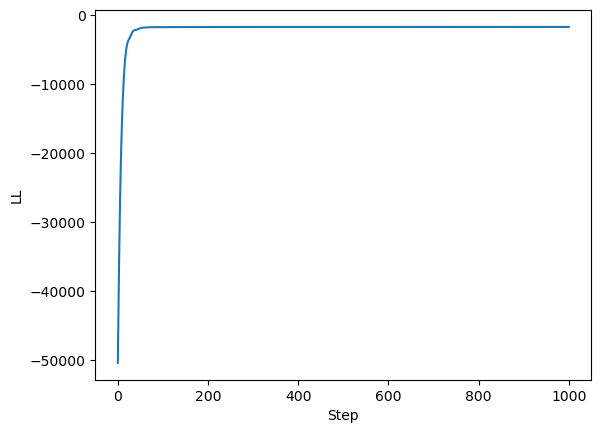

In [ ]:
A = np.load('A.npy')
A = torch.Tensor(A[None, ...]).to(device)
Q = np.load('Q.npy')
B = np.linalg.cholesky(Q)
B = torch.Tensor(B[None, ...]).to(device)
mu0 = np.load('mu0.npy')
mu0 = torch.Tensor(mu0[None, ...]).to(device)
Sigma0 = np.load('Sigma0.npy')
Sigma0_half = np.linalg.cholesky(Sigma0)
Sigma0_half = torch.Tensor(Sigma0_half[None, ...]).to(device)

np.random.seed(0)
torch.manual_seed(0)
link_fn = torch.functional.F.softplus
# link_fn = torch.exp
lik = Poisson_noise()
# model = LDS(z, Y_train, lik, link_fn=link_fn)
model = LDS(z, Y_train, lik, link_fn=link_fn, A=A, B=B, mu0=mu0, Sigma0_half=Sigma0_half, trained_z=True)
print(model.N, model.T, model.x_dim, model.b, model.ntrials)
train_params = {'batch_size': None, 'n_mc': 500, 'lrate': 2.5e-2, 'max_steps': 1001, 'step_size': 100}
model.train_supervised_model(model.training_params(**train_params))
model.plot_LL()

In [ ]:
for name, prm in model.named_parameters():
    print(f'Name: {name} - Shape: {prm.shape} - Parameter: {prm}')

# print(Q - (B @ B.transpose(-1,-2)).detach().cpu().numpy())
print(model.C @ model.W)
print(torch.linalg.det(model.Sigma0))


Name: A - Shape: torch.Size([1, 10, 10]) - Parameter: Parameter containing:
tensor([[[ 0.6913, -0.0256,  0.2221,  0.0040, -0.0826,  0.1810, -0.3196,
           0.1486,  0.0076,  0.0034],
         [-0.0798,  0.6710,  0.0188,  0.1977,  0.2383,  0.0478,  0.1546,
          -0.1074, -0.0171, -0.0076],
         [-0.0625, -0.0795,  0.5759, -0.3632, -0.1376,  0.0087, -0.0825,
          -0.2804, -0.2230, -0.2442],
         [-0.1767, -0.1861,  0.1713,  0.6299, -0.0075, -0.3032, -0.0699,
           0.1272,  0.1840, -0.0165],
         [ 0.1895, -0.2065, -0.1416,  0.1101,  0.7058,  0.0242,  0.0279,
           0.0563,  0.2337,  0.3023],
         [-0.1806, -0.2366,  0.1210,  0.1383, -0.0689,  0.5664, -0.0441,
           0.0316, -0.0749, -0.0255],
         [ 0.3200, -0.1526, -0.1148, -0.0411,  0.1968, -0.2946,  0.5438,
           0.0426,  0.2977,  0.4728],
         [ 0.1141, -0.0116,  0.3919, -0.0774, -0.1152, -0.0455, -0.2086,
           0.6251, -0.0791, -0.0848],
         [ 0.0178, -0.0096, -0.0319,

torch.Size([3, 400, 10, 16])


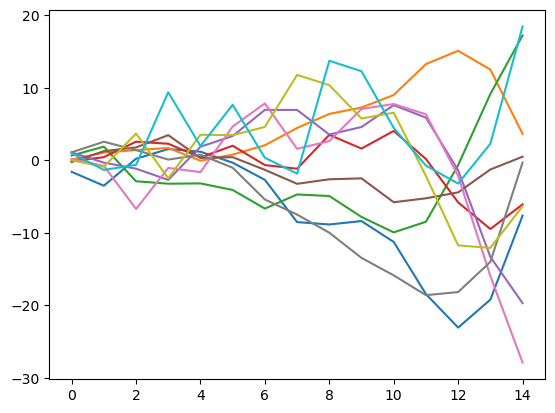

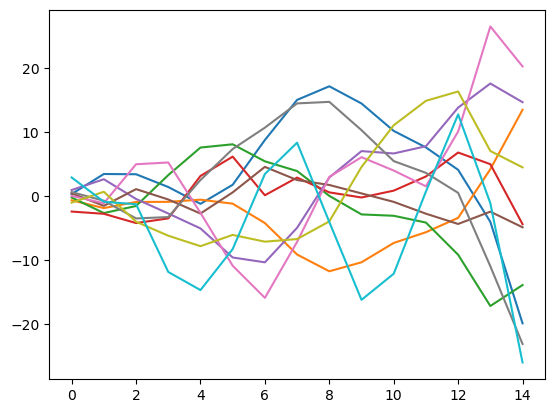

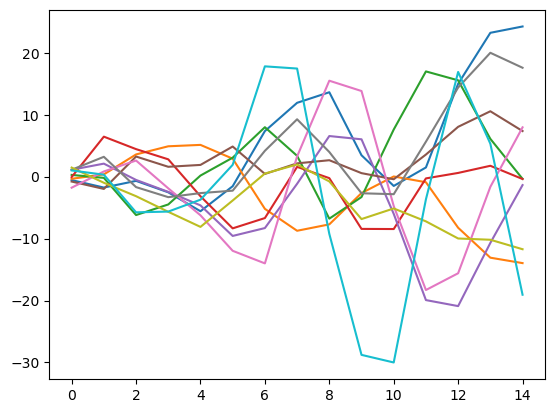

In [ ]:
z_samps = model.sample_z(3)
print(z_samps.shape)
stop = -1
for i in range(len(z_samps)):
    for j in range(10):
        plt.plot(z_samps[i,0,j, :stop].detach().cpu().numpy())
    plt.show()

In [ ]:
model.freeze_params()
rec_model = RecognitionModel(model)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 5e-2, 'max_steps': 1001, 'n_mc_x': 100, 'n_mc_z': 100}
rec_model.train_recognition_model(rec_model.training_params(**train_params))
rec_model.plot_LL()

ValueError: Expected parameter covariance_matrix (Tensor of shape (16, 100, 400, 10, 10)) of distribution MultivariateNormal(loc: torch.Size([16, 100, 400, 10]), covariance_matrix: torch.Size([16, 100, 400, 10, 10])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[[[[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          ...,

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]]],


         [[[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          ...,

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]]],


         [[[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          ...,

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]]],


         ...,


         [[[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          ...,

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]]],


         [[[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          ...,

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]]],


         [[[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          ...,

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]],

          [[ 8.7896e-02, -3.1978e-02,  6.0750e-03,  ..., -1.4014e-02,
            -4.8764e-02,  4.5582e-03],
           [-3.1979e-02,  1.7854e-02, -9.9425e-03,  ..., -1.0596e-02,
             2.2659e-03, -1.7803e-02],
           [ 6.0867e-03, -9.9237e-03,  4.5247e-02,  ...,  2.9676e-02,
            -3.1305e-03,  4.2825e-03],
           ...,
           [-1.4018e-02, -1.0601e-02,  2.9698e-02,  ...,  7.0094e-02,
             5.0550e-02,  6.2749e-02],
           [-4.8721e-02,  2.2695e-03, -3.0740e-03,  ...,  5.0528e-02,
             3.9466e-01,  1.3073e-01],
           [ 4.5376e-03, -1.7810e-02,  4.1976e-03,  ...,  6.2775e-02,
             1.3083e-01,  2.4069e-01]]]],



        [[[[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          ...,

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]]],


         [[[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          ...,

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]]],


         [[[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          ...,

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]]],


         ...,


         [[[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          ...,

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]]],


         [[[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          ...,

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]]],


         [[[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          ...,

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]],

          [[ 1.0846e-01, -4.4321e-02,  2.3210e-02,  ..., -1.2085e-03,
            -6.8535e-02,  1.8394e-02],
           [-4.4318e-02,  2.8349e-02, -2.2199e-02,  ..., -2.7369e-02,
            -9.1994e-03, -3.5589e-02],
           [ 2.3231e-02, -2.2267e-02,  8.1343e-02,  ...,  3.9701e-02,
            -3.2286e-02,  1.7454e-02],
           ...,
           [-1.2144e-03, -2.7364e-02,  3.9632e-02,  ...,  1.1612e-01,
             1.4443e-01,  1.3007e-01],
           [-6.8515e-02, -9.1326e-03, -3.2631e-02,  ...,  1.4443e-01,
             7.4287e-01,  3.2793e-01],
           [ 1.8353e-02, -3.5690e-02,  1.7966e-02,  ...,  1.3003e-01,
             3.2800e-01,  4.9808e-01]]]],



        [[[[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          ...,

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]]],


         [[[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          ...,

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]]],


         [[[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          ...,

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]]],


         ...,


         [[[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          ...,

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]]],


         [[[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          ...,

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]]],


         [[[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          ...,

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]],

          [[ 1.1418e-01, -4.2658e-02,  2.0647e-02,  ...,  2.1961e-03,
            -8.1190e-02,  3.3810e-02],
           [-4.2638e-02,  5.6662e-02, -4.9831e-02,  ..., -4.1062e-02,
            -7.5296e-02,  4.1884e-02],
           [ 2.0611e-02, -4.9739e-02,  1.1406e-01,  ...,  5.0912e-02,
             2.7489e-02, -5.7572e-02],
           ...,
           [ 2.1879e-03, -4.1084e-02,  5.0988e-02,  ...,  1.2701e-01,
             1.7271e-01,  1.0242e-01],
           [-8.1206e-02, -7.5279e-02,  2.7583e-02,  ...,  1.7269e-01,
             9.2026e-01,  1.3489e-01],
           [ 3.3847e-02,  4.1939e-02, -5.7848e-02,  ...,  1.0245e-01,
             1.3482e-01,  7.5375e-01]]]],



        ...,



        [[[[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          ...,

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]]],


         [[[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          ...,

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]]],


         [[[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          ...,

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]]],


         ...,


         [[[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          ...,

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]]],


         [[[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          ...,

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]]],


         [[[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          ...,

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]],

          [[ 1.3036e-01, -3.1262e-02, -1.7265e-02,  ...,  1.5125e-02,
            -1.0941e-01,  6.4493e-02],
           [-3.1265e-02,  8.6159e-02, -8.1703e-02,  ..., -4.3729e-02,
            -1.5241e-01,  1.4680e-01],
           [-1.7238e-02, -8.1683e-02,  2.5237e-01,  ...,  1.6157e-02,
             7.1724e-02, -6.6902e-02],
           ...,
           [ 1.5124e-02, -4.3731e-02,  1.6154e-02,  ...,  1.4514e-01,
             1.8752e-01,  6.9086e-02],
           [-1.0941e-01, -1.5243e-01,  7.1743e-02,  ...,  1.8753e-01,
             1.1500e+00, -2.0141e-01],
           [ 6.4490e-02,  1.4682e-01, -6.6874e-02,  ...,  6.9088e-02,
            -2.0141e-01,  1.2788e+00]]]],



        [[[[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          ...,

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]]],


         [[[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          ...,

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]]],


         [[[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          ...,

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]]],


         ...,


         [[[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          ...,

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]]],


         [[[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          ...,

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]]],


         [[[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          ...,

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]],

          [[ 1.3035e-01, -3.1269e-02, -1.7190e-02,  ...,  1.5106e-02,
            -1.0945e-01,  6.4559e-02],
           [-3.1270e-02,  8.6427e-02, -8.1620e-02,  ..., -4.3910e-02,
            -1.5328e-01,  1.4806e-01],
           [-1.7175e-02, -8.1636e-02,  2.5301e-01,  ...,  1.6117e-02,
             7.1096e-02, -6.5320e-02],
           ...,
           [ 1.5108e-02, -4.3894e-02,  1.6087e-02,  ...,  1.4524e-01,
             1.8807e-01,  6.8206e-02],
           [-1.0940e-01, -1.5315e-01,  7.0822e-02,  ...,  1.8810e-01,
             1.1528e+00, -2.0613e-01],
           [ 6.4543e-02,  1.4799e-01, -6.5143e-02,  ...,  6.8201e-02,
            -2.0619e-01,  1.2871e+00]]]],



        [[[[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          ...,

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]]],


         [[[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          ...,

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]]],


         [[[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          ...,

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]]],


         ...,


         [[[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          ...,

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]]],


         [[[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          ...,

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]]],


         [[[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          ...,

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]],

          [[ 6.6671e+00, -4.8064e+00, -4.9359e-02,  ...,  5.1973e+00,
             1.0160e+00,  1.6131e+00],
           [-4.8064e+00,  4.1476e+00, -1.0716e+00,  ..., -4.2069e+00,
            -2.4019e+00, -1.0251e+00],
           [-4.9353e-02, -1.0716e+00,  4.9084e+00,  ...,  1.0145e+00,
             9.1482e-01,  3.0719e+00],
           ...,
           [ 5.1973e+00, -4.2069e+00,  1.0145e+00,  ...,  5.3607e+00,
             3.7334e+00,  3.8549e+00],
           [ 1.0160e+00, -2.4019e+00,  9.1482e-01,  ...,  3.7334e+00,
             1.0428e+01,  3.4394e+00],
           [ 1.6131e+00, -1.0251e+00,  3.0719e+00,  ...,  3.8549e+00,
             3.4394e+00,  1.0689e+01]]]]], device='cuda:0')